# 1.27b: Thimble 3 Radius from Centroid

**Purpose:** Separate cloud expansion from centroid drift.

In 1.27a we measured radius from origin and saw continued growth through late training. But this conflates two dynamics:

1. **Cloud expansion**: Dead tokens moving apart from each other
2. **Centroid drift**: The whole cloud wandering through space

To isolate the true expansion dynamics, we measure radius from the cloud's centroid at each timestep.

## What We'll Compute

- **Centroid position**: $\mathbf{c}(t) = \frac{1}{N}\sum_{i=1}^{N} \mathbf{w}_i(t)$ for dead tokens
- **Radius from origin**: $r_{\text{origin}}(t) = \frac{1}{N}\sum_{i=1}^{N} \|\mathbf{w}_i(t)\|$
- **Radius from centroid**: $r_{\text{centroid}}(t) = \frac{1}{N}\sum_{i=1}^{N} \|\mathbf{w}_i(t) - \mathbf{c}(t)\|$
- **Centroid drift**: $\|\mathbf{c}(t) - \mathbf{c}(0)\|$

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Thimble/thimble_3.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Thimble 3 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix (convert to float32)
W = data['W'].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Thimble 3 data...

W shape: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Compute Centroid and Radii

In [5]:
print("Computing centroid and radii...\n")

# Extract dead tokens
W_dead = W[:, dead_mask, :]  # (1001, n_dead, 64)

# Centroid at each timestep
centroid = W_dead.mean(dim=1)  # (1001, 64)

# Radius from origin
radii_origin = torch.norm(W_dead, dim=2)  # (1001, n_dead)
mean_radius_origin = radii_origin.mean(dim=1)  # (1001,)

# Radius from centroid
# Broadcasting: W_dead is (1001, n_dead, 64), centroid is (1001, 64)
# Need to expand centroid to (1001, 1, 64) to broadcast correctly
centroid_expanded = centroid.unsqueeze(1)  # (1001, 1, 64)
radii_centroid = torch.norm(W_dead - centroid_expanded, dim=2)  # (1001, n_dead)
mean_radius_centroid = radii_centroid.mean(dim=1)  # (1001,)

# Centroid drift (distance from initial centroid)
centroid_drift = torch.norm(centroid - centroid[0], dim=1)  # (1001,)

print(f"Centroid shape: {tuple(centroid.shape)}")
print(f"Mean radius from origin: {tuple(mean_radius_origin.shape)}")
print(f"Mean radius from centroid: {tuple(mean_radius_centroid.shape)}")
print(f"Centroid drift: {tuple(centroid_drift.shape)}")
print(f"\n✓ Centroid and radii computed")

Computing centroid and radii...

Centroid shape: (1001, 64)
Mean radius from origin: (1001,)
Mean radius from centroid: (1001,)
Centroid drift: (1001,)

✓ Centroid and radii computed


## Compare Radii: Origin vs. Centroid

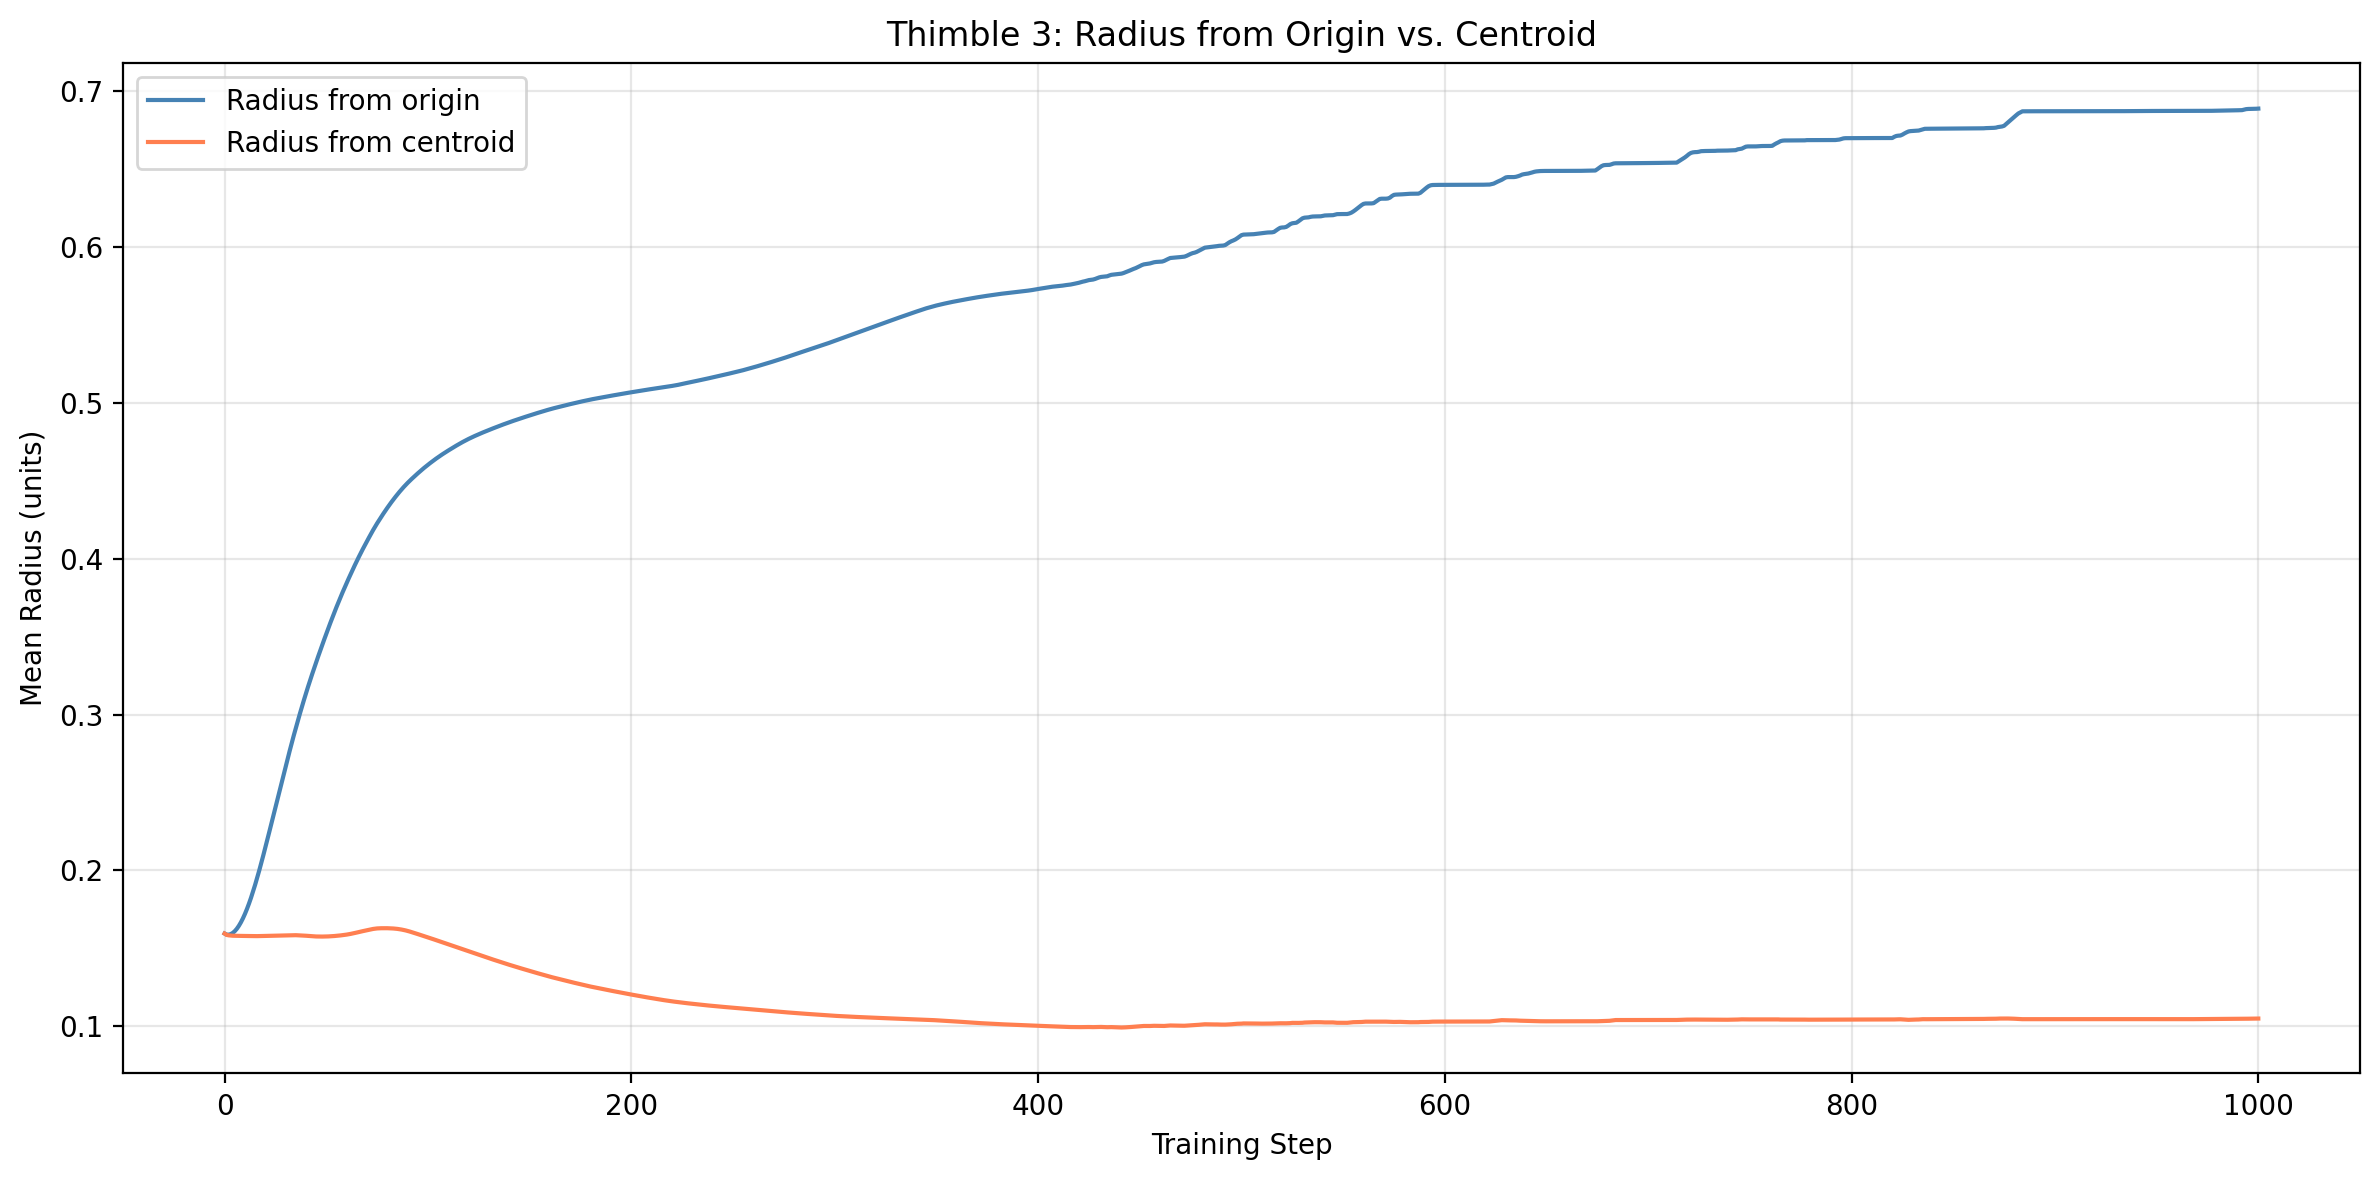

Interpretation:
  - If origin and centroid radii diverge → centroid is drifting
  - If centroid radius is constant → cloud isn't expanding, just drifting
  - If centroid radius varies → true expansion/contraction dynamics


In [6]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_radius_origin.numpy(), linewidth=1.5, color='steelblue', label='Radius from origin')
ax.plot(mean_radius_centroid.numpy(), linewidth=1.5, color='coral', label='Radius from centroid')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius (units)')
ax.set_title('Thimble 3: Radius from Origin vs. Centroid')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - If origin and centroid radii diverge → centroid is drifting")
print("  - If centroid radius is constant → cloud isn't expanding, just drifting")
print("  - If centroid radius varies → true expansion/contraction dynamics")

## Centroid Drift Over Time

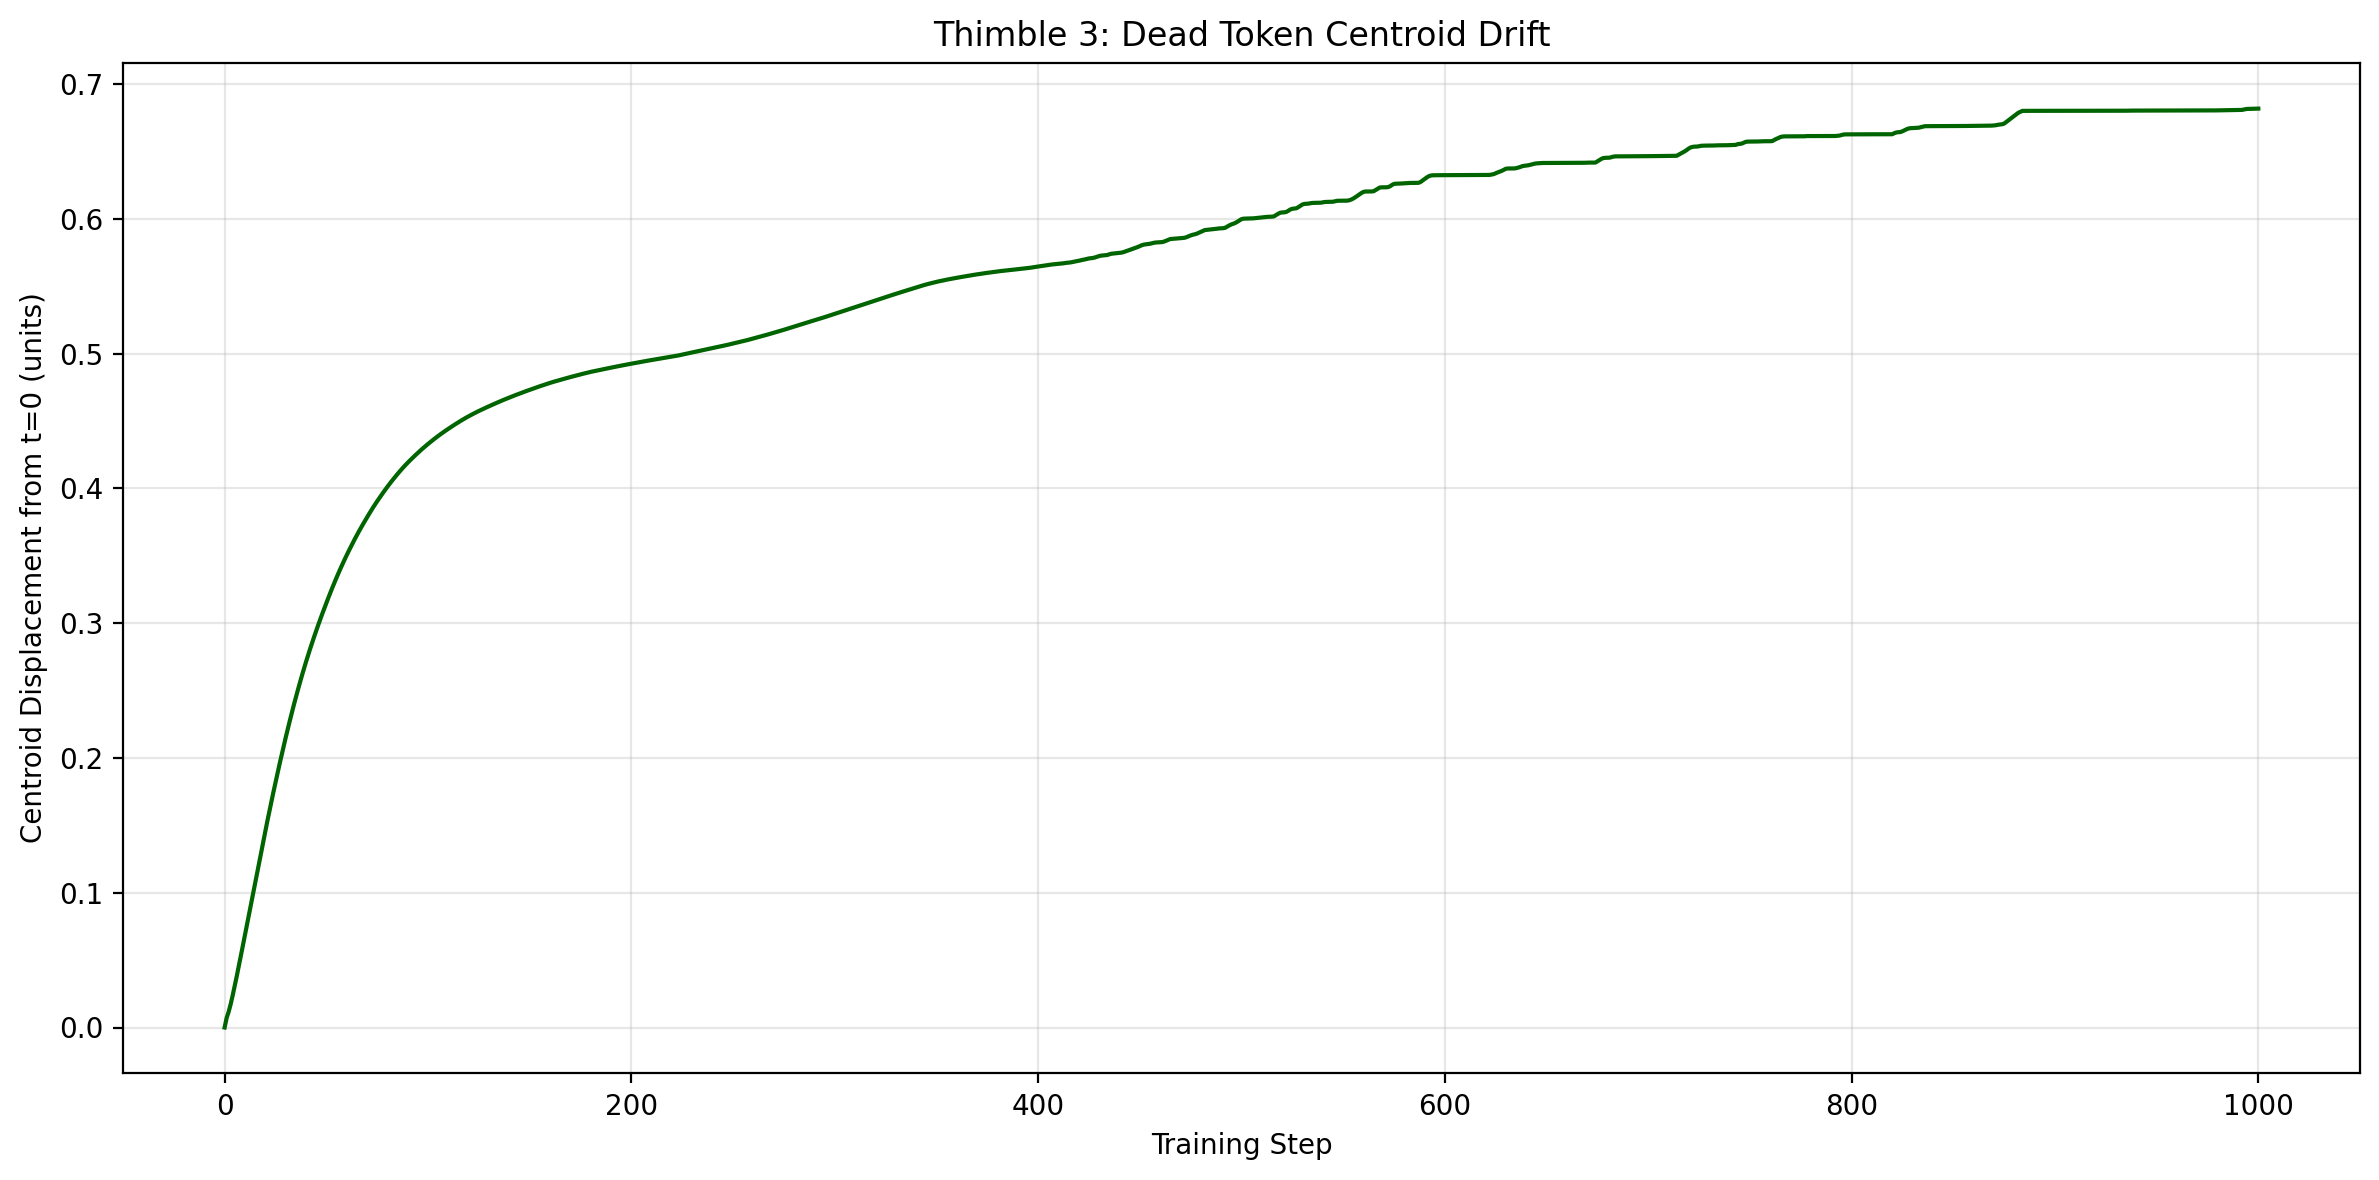


Centroid drift statistics:
  Initial position norm: 0.002740 units
  Final position norm: 0.681557 units
  Total drift: 0.681816 units
  Drift / initial radius: 4.28×


In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(centroid_drift.numpy(), linewidth=1.5, color='darkgreen')

ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Displacement from t=0 (units)')
ax.set_title('Thimble 3: Dead Token Centroid Drift')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCentroid drift statistics:")
print(f"  Initial position norm: {torch.norm(centroid[0]).item():.6f} units")
print(f"  Final position norm: {torch.norm(centroid[-1]).item():.6f} units")
print(f"  Total drift: {centroid_drift[-1].item():.6f} units")
print(f"  Drift / initial radius: {(centroid_drift[-1] / mean_radius_centroid[0]).item():.2f}×")

## Velocity and Acceleration from Centroid Radius

In [8]:
print("Computing velocity and acceleration from centroid-based radius...\n")

# Velocity (first derivative of centroid radius)
velocity_centroid = torch.diff(mean_radius_centroid)  # (1000,)

# Acceleration (second derivative)
acceleration_centroid = torch.diff(velocity_centroid)  # (999,)

print(f"Velocity: {tuple(velocity_centroid.shape)}")
print(f"Acceleration: {tuple(acceleration_centroid.shape)}")
print(f"\n✓ Kinematics computed")

Computing velocity and acceleration from centroid-based radius...

Velocity: (1000,)
Acceleration: (999,)

✓ Kinematics computed


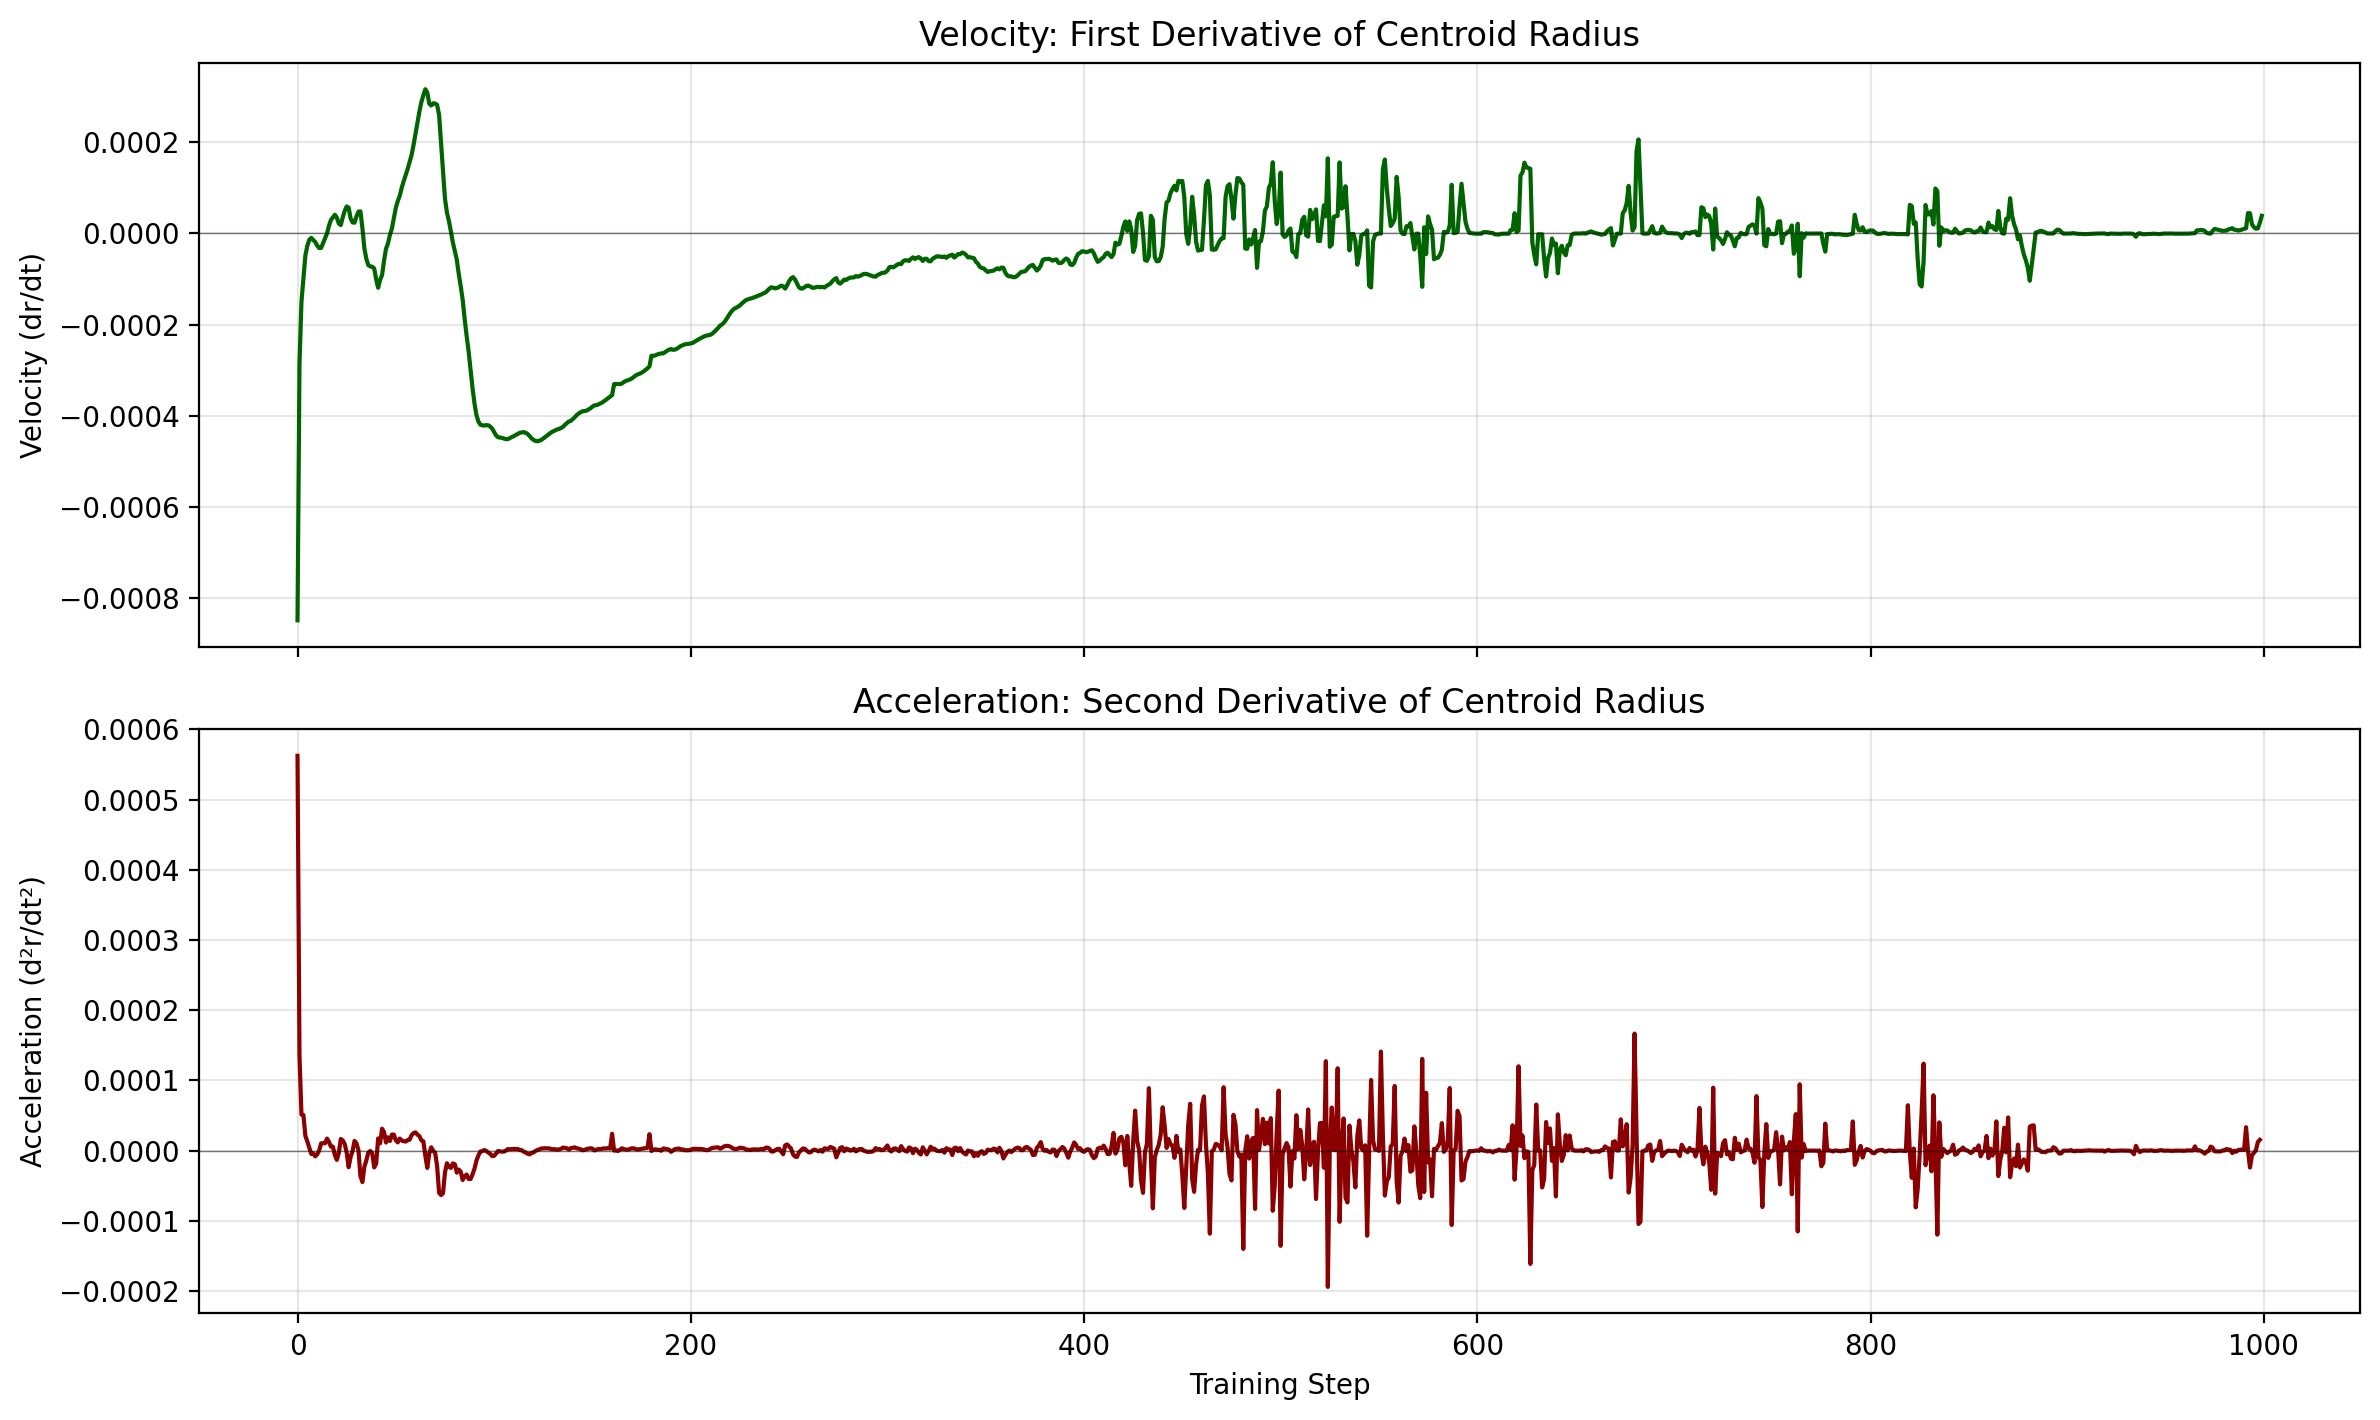

Interpretation: These show the TRUE expansion dynamics, isolated from drift.


In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.2), dpi=DPI, sharex=True)

# Velocity
ax1.plot(velocity_centroid.numpy(), linewidth=1.5, color='darkgreen')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_ylabel('Velocity (dr/dt)')
ax1.set_title('Velocity: First Derivative of Centroid Radius')
ax1.grid(True, alpha=0.3)

# Acceleration
ax2.plot(acceleration_centroid.numpy(), linewidth=1.5, color='darkred')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Acceleration (d²r/dt²)')
ax2.set_title('Acceleration: Second Derivative of Centroid Radius')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation: These show the TRUE expansion dynamics, isolated from drift.")

## Epoch Detection from Centroid Radius

In [10]:
print("="*80)
print("EPOCH DETECTION FROM CENTROID RADIUS")
print("="*80 + "\n")

# Sneeze ends at peak velocity
t_sneeze_end = velocity_centroid.argmax().item()

# Fimbulwinter starts when >90% frozen
displacements = torch.norm(W_dead[1:] - W_dead[:-1], dim=2)  # (1000, n_dead)
frozen_mask = (displacements == 0)
fraction_frozen = frozen_mask.float().mean(dim=1)
fimbulwinter_mask = fraction_frozen > 0.9

if fimbulwinter_mask.any():
    t_fimbulwinter_start = fimbulwinter_mask.nonzero()[0].item()
else:
    t_fimbulwinter_start = len(fraction_frozen)

print(f"The Sneeze:")
print(f"  Start: t=0")
print(f"  End:   t={t_sneeze_end} (peak velocity)")
print(f"  Peak velocity: {velocity_centroid[t_sneeze_end]:.6f} units/step")
print()

print(f"Deceleration:")
print(f"  Start: t={t_sneeze_end}")
print(f"  End:   t={t_fimbulwinter_start} (Fimbulwinter onset)")
print(f"  Duration: {t_fimbulwinter_start - t_sneeze_end} steps")
print()

print(f"Fimbulwinter:")
print(f"  Start: t={t_fimbulwinter_start}")
print(f"  End:   t={len(mean_radius_centroid)-1}")
print(f"  Duration: {len(mean_radius_centroid) - 1 - t_fimbulwinter_start} steps")

print("\n" + "="*80 + "\n")

EPOCH DETECTION FROM CENTROID RADIUS

The Sneeze:
  Start: t=0
  End:   t=65 (peak velocity)
  Peak velocity: 0.000316 units/step

Deceleration:
  Start: t=65
  End:   t=562 (Fimbulwinter onset)
  Duration: 497 steps

Fimbulwinter:
  Start: t=562
  End:   t=1000
  Duration: 438 steps




## Centroid Radius with Epoch Boundaries

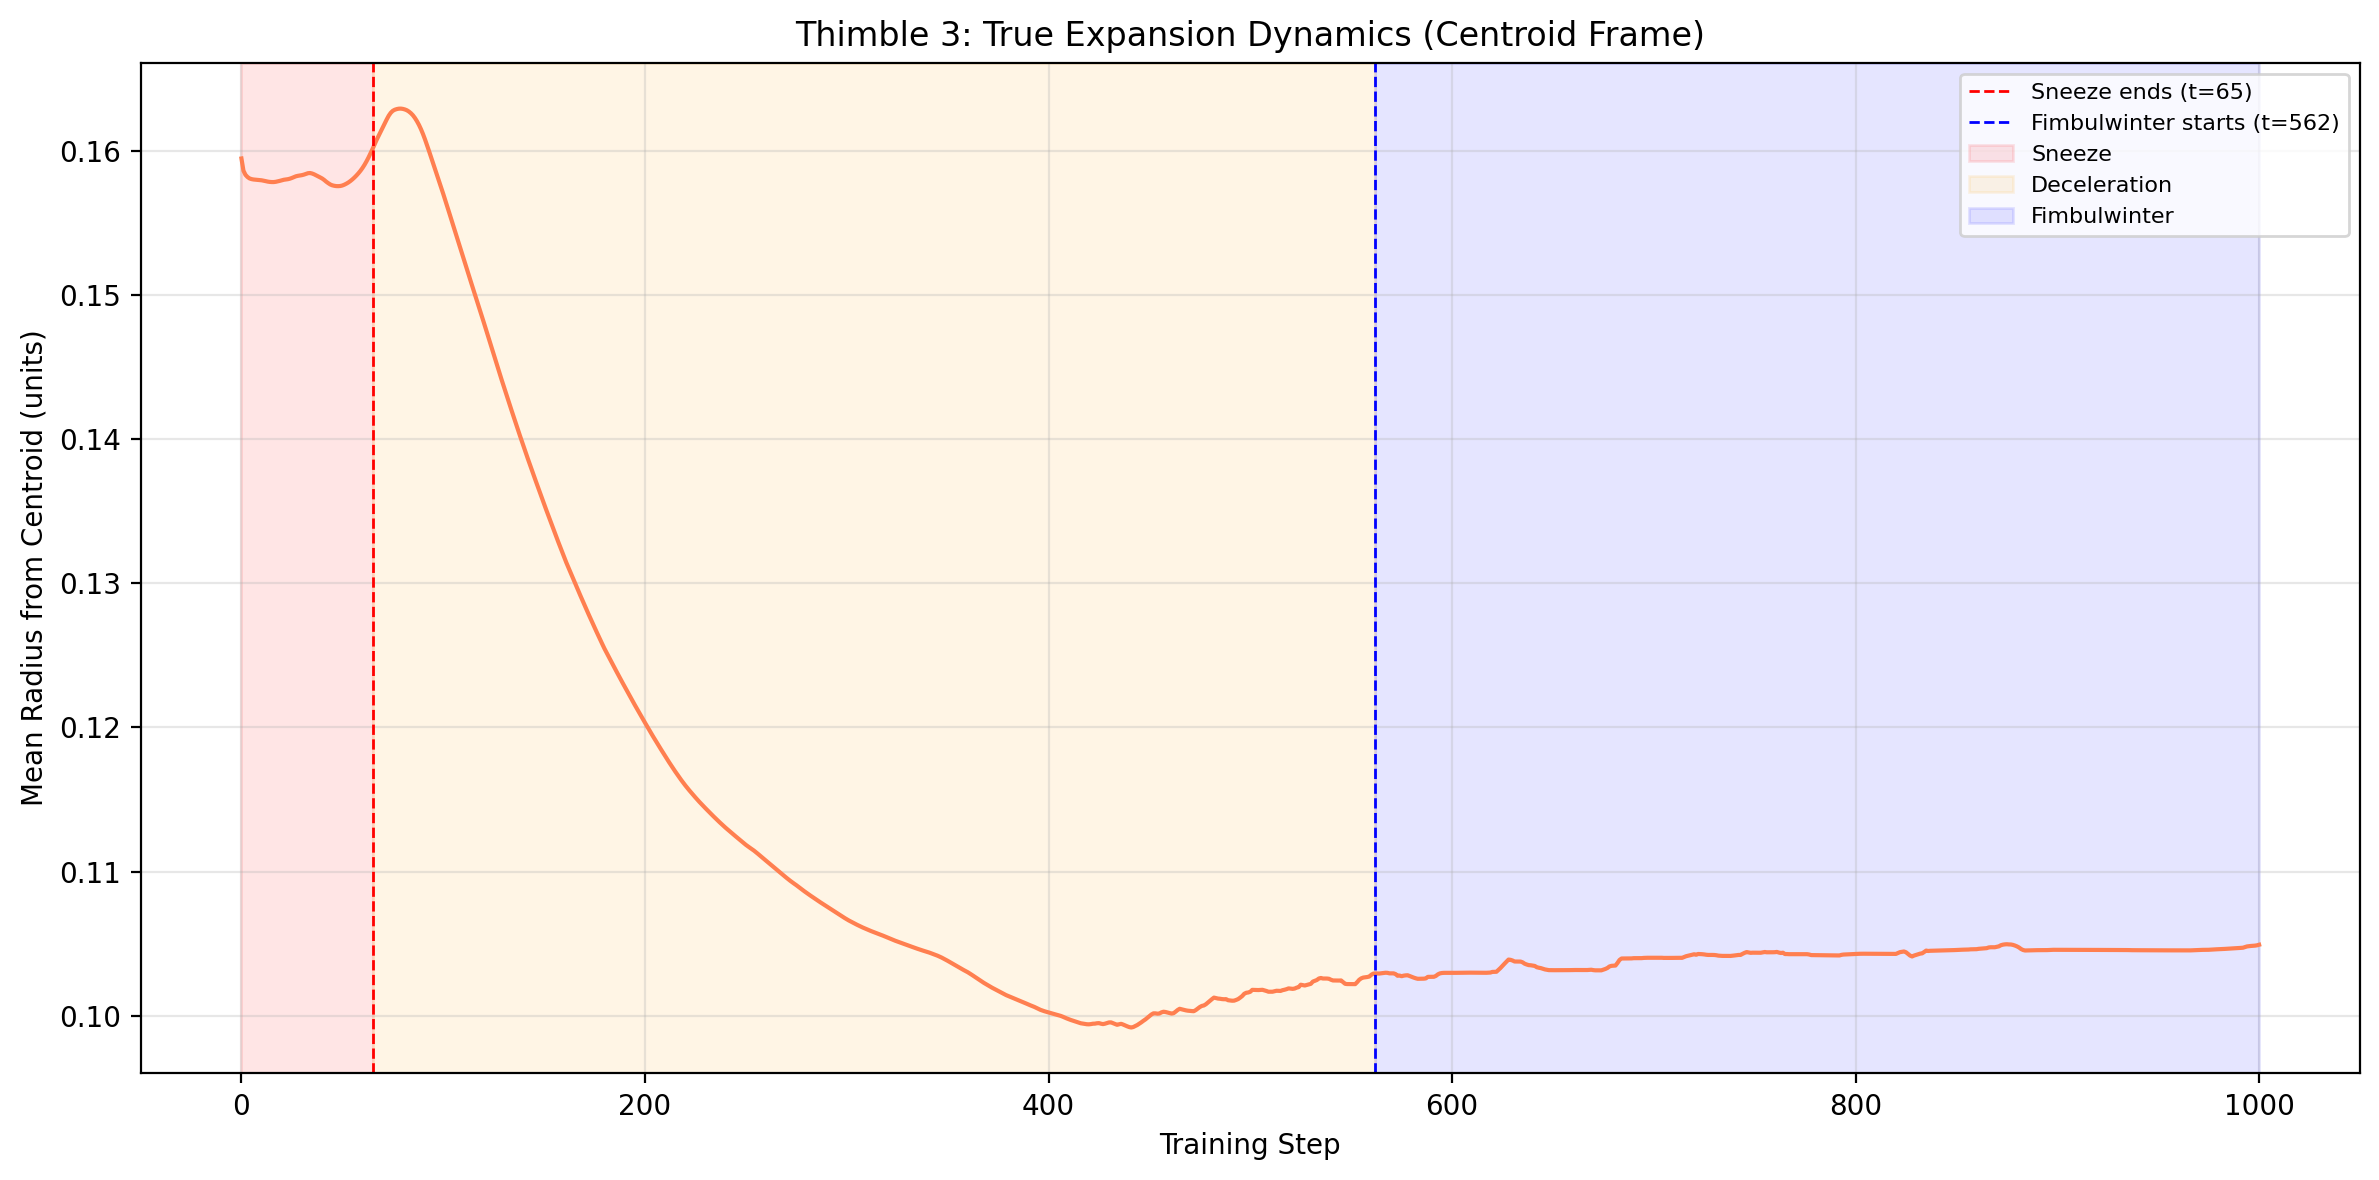

In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_radius_centroid.numpy(), linewidth=1.5, color='coral')

# Mark epoch boundaries
ax.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, label=f'Sneeze ends (t={t_sneeze_end})')
ax.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, label=f'Fimbulwinter starts (t={t_fimbulwinter_start})')

# Shade epochs
ax.axvspan(0, t_sneeze_end, alpha=0.1, color='red', label='Sneeze')
ax.axvspan(t_sneeze_end, t_fimbulwinter_start, alpha=0.1, color='orange', label='Deceleration')
ax.axvspan(t_fimbulwinter_start, len(mean_radius_centroid)-1, alpha=0.1, color='blue', label='Fimbulwinter')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius from Centroid (units)')
ax.set_title('Thimble 3: True Expansion Dynamics (Centroid Frame)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [12]:
print("\n" + "="*80)
print("SUMMARY: CENTROID VS. ORIGIN ANALYSIS")
print("="*80 + "\n")

# Net changes
radius_origin_change = mean_radius_origin[-1] / mean_radius_origin[0]
radius_centroid_change = mean_radius_centroid[-1] / mean_radius_centroid[0]
drift_vs_initial_radius = centroid_drift[-1] / mean_radius_centroid[0]

print("Radius from origin:")
print(f"  Initial: {mean_radius_origin[0]:.6f} units")
print(f"  Final:   {mean_radius_origin[-1]:.6f} units")
print(f"  Change:  {radius_origin_change:.2f}× ({(radius_origin_change-1)*100:+.1f}%)")
print()

print("Radius from centroid:")
print(f"  Initial: {mean_radius_centroid[0]:.6f} units")
print(f"  Final:   {mean_radius_centroid[-1]:.6f} units")
print(f"  Change:  {radius_centroid_change:.2f}× ({(radius_centroid_change-1)*100:+.1f}%)")
print()

print("Centroid drift:")
print(f"  Total displacement: {centroid_drift[-1]:.6f} units")
print(f"  Drift / initial cloud radius: {drift_vs_initial_radius:.2f}×")
print()

if radius_centroid_change > 1.1:
    print("✓ Cloud is expanding (radius from centroid increased)")
elif radius_centroid_change < 0.9:
    print("✓ Cloud is contracting (radius from centroid decreased)")
else:
    print("✓ Cloud is approximately stable (radius from centroid unchanged)")

if drift_vs_initial_radius > 0.5:
    print("✓ Significant centroid drift detected")
else:
    print("✓ Minimal centroid drift")

print("\n" + "="*80)
print("✓ Analysis complete.")
print("="*80)


SUMMARY: CENTROID VS. ORIGIN ANALYSIS

Radius from origin:
  Initial: 0.159489 units
  Final:   0.688936 units
  Change:  4.32× (+332.0%)

Radius from centroid:
  Initial: 0.159466 units
  Final:   0.104927 units
  Change:  0.66× (-34.2%)

Centroid drift:
  Total displacement: 0.681816 units
  Drift / initial cloud radius: 4.28×

✓ Cloud is contracting (radius from centroid decreased)
✓ Significant centroid drift detected

✓ Analysis complete.
